In [1]:
from warnings import filterwarnings
filterwarnings(action ="ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix


In [2]:
train = pd.read_csv("C:\\Users\\MY PC\\OneDrive\\Desktop\\data_train.csv")
train.head(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1112b,CUS0x3943,February,Jessicaf,30,#F%$D@*&8,Lawyer,18859.38,1360.61500,6,...,Standard,330.26,27.911640,13 Years and 3 Months,Yes,40.292010,59.60664697,Low_spent_Large_value_payments,306.1628428,Standard
1,0x22dd0,CUS0x90d0,July,Langel,39,047-17-4695,Writer,46477.56,4059.13000,7,...,Bad,1799.87,32.851676,9 Years and 2 Months,NM,212.248190,109.4092923,High_spent_Medium_value_payments,334.2555174,Poor
2,0x19ae8,CUS0x6e95,July,Louise Eganb,52,369-09-8718,Mechanic,153147.64,12915.30333,5,...,Good,1222.96,40.264738,25 Years and 8 Months,No,81.918963,152.9087468,High_spent_Medium_value_payments,1306.702624,Poor
3,0x1e584,CUS0x26da,March,Alwyn Scottz,39,957-74-9111,Doctor,16833.105,1542.75875,5,...,Good,35.71,30.634617,19 Years and 4 Months,No,51.702938,160.0692534,Low_spent_Small_value_payments,232.5036833,Good
4,0x648a,CUS0x473a,May,Roumeliotisu,31,720-32-3844,Media_Manager,131693.37_,10696.44750,0,...,Good,1428.94,29.807968,22 Years and 3 Months,No,208.858473,1084.704299,Low_spent_Medium_value_payments,56.08197761,Standard


In [3]:
len(train['Customer_ID'].unique())

12500

In [4]:
list = ['ID','Name','SSN']
train = train.drop(columns=list, axis = 1)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Month                     100000 non-null  object 
 2   Age                       100000 non-null  object 
 3   Occupation                97910 non-null   object 
 4   Annual_Income             100000 non-null  object 
 5   Monthly_Inhand_Salary     84998 non-null   float64
 6   Num_Bank_Accounts         100000 non-null  int64  
 7   Num_Credit_Card           100000 non-null  int64  
 8   Interest_Rate             100000 non-null  int64  
 9   Num_of_Loan               100000 non-null  object 
 10  Type_of_Loan              88592 non-null   object 
 11  Delay_from_due_date       100000 non-null  int64  
 12  Num_of_Delayed_Payment    92998 non-null   object 
 13  Changed_Credit_Limit      99395 non-null   ob

# Data Cleaning

In [6]:
def column_details(data, column):
    print("\n------------------------------------------------------------------")
    print(f"Initial Information of {column}")
    print(f"\nNull values in the column: {data[column].isnull().sum()}")
    print(f"\nUnique Values: {len(data[column].unique())}")
    print(f"\nDistribution of Values:\n{data[column].value_counts()}")
    if data[column].dtype != "object":
        print(f"\nMinimum and Max values:\n{data[column].agg(['min','max'])}")
    print("\nCleaning Steps")

In [7]:
def fill_with_mode(data, column, groupby):
    mode_column = data.groupby(groupby)[column].agg(lambda x: x.mode()[0] if not x.mode().empty else x.iloc[0])
    # Fill NaN values in the column with the mode occupation for each customer
    data[column] = data[column].fillna(data[groupby].map(mode_column))

    print(f"\nNull Values in the column after mode filling: {data[column].isnull().sum()}")
    print("\n------------------------------------------------------------------------------------")

In [8]:
def cleaning_categorical_values(data, column, groupby, replace_value = None):

    if replace_value != None:
        data[column].replace(replace_value, np.nan, inplace = True)
    print(f"\nNull Values after replacing garbage: {data[column].isnull().sum()}")
    #fill blank values
    fill_with_mode(data, column, groupby)     
    if data[column].isnull().sum()>0:
        data[column].fillna('Not Specified', inplace = True)
        print(f"Null Values now: {data[column].isnull().sum()}")

In [9]:
def inconsistent_values(data, column, groupby):
    mode_list = data[data[column].notna()].groupby(groupby)[column].agg(lambda x: x.mode()[0])
    mini, maxi = min(mode_list), max(mode_list)
    
    data[column] = data[column].apply(lambda x: np.NaN if (x<mini or x>maxi or x<0) else x)
    mode_by_group = data.groupby(groupby)[column].agg(lambda x: x.mode()[0] if not x.mode().empty else np.NaN)
    data[column] = data[column].fillna(data[groupby].map(mode_by_group))
    data[column].fillna(int(data[column].mean()), inplace = True)
    
    print('\nThe number of null values:',data[column].isnull().sum())
    print('\nThe max and min values:',data[column].min(),',', data[column].max())
    print("\n------------------------------------------------------------------------")

In [10]:
#Method to clean Numerical Field
def clean_numerical_field(data,column,groupby,strip=None,datatype=None,replace_value=None):
    print("\n-----------------------------------------------------")
    
    #Replace with np.nan
    if replace_value!=None:
        data[column] = data[column].replace(replace_value,np.NaN)
        print(f"\nGarbage value {replace_value} is replaced with np.nan")
        
    # Remove trailing & leading special characters
    if data[column].dtype == object and strip is not None:
        data[column] = data[column].str.strip(strip)
        print(f"\nTrailing & leading {strip} are removed")

    # Change datatype
    if datatype is not None:
        data[column] = data[column].astype(datatype)
        print(f"\nDatatype of {column} is changed to {datatype}")

    inconsistent_values(data,column, groupby)

In [11]:
train.columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [12]:
#Occupation
column_details(train, "Occupation")
cleaning_categorical_values(train, "Occupation", "Customer_ID", replace_value="_______")


------------------------------------------------------------------
Initial Information of Occupation

Null values in the column: 2090

Unique Values: 18

Distribution of Values:
Occupation
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
_______          4972
Media_Manager    4359
MediaManager     1873
Name: count, dtype: int64

Cleaning Steps

Null Values after replacing garbage: 7062

Null Values in the column after mode filling: 0

------------------------------------------------------------------------------------


In [13]:
#Month
train['Month'] = pd.to_datetime(train.Month, format='%B').dt.month

In [14]:
#Type of Loan
column_details(train, "Type_of_Loan")
cleaning_categorical_values(train, "Occupation", "Customer_ID", replace_value=None)
train['Type_of_Loan'].replace([np.NaN], 'Not Specified', inplace=True)


------------------------------------------------------------------
Initial Information of Type_of_Loan

Null values in the column: 11408

Unique Values: 6261

Distribution of Values:
Type_of_Loan
Not Specified                                                                                           1408
Credit-Builder Loan                                                                                     1280
Personal Loan                                                                                           1272
Debt Consolidation Loan                                                                                 1264
Student Loan                                                                                            1240
                                                                                                        ... 
Student Loan, Student Loan, Not Specified, and Debt Consolidation Loan                                     8
Not Specified, Mortgage Loan, Mortgage L

In [15]:
#Payment Behaviour
column_details(train, "Payment_Behaviour")
cleaning_categorical_values(train, "Payment_Behaviour", "Customer_ID", "!@9#%8")


------------------------------------------------------------------
Initial Information of Payment_Behaviour

Null values in the column: 0

Unique Values: 13

Distribution of Values:
Payment_Behaviour
Low_spent_Small_value_payments      17876
High_spent_Medium_value_payments    12307
High_spent_Large_value_payments      9717
Low_spent_Medium_value_payments      9667
High_spent_Small_value_payments      7909
LowspentSmallvaluepayments           7637
!@9#%8                               7600
Low_spent_Large_value_payments       7214
HighspentMediumvaluepayments         5233
LowspentMediumvaluepayments          4194
HighspentLargevaluepayments          4004
HighspentSmallvaluepayments          3431
LowspentLargevaluepayments           3211
Name: count, dtype: int64

Cleaning Steps

Null Values after replacing garbage: 7600

Null Values in the column after mode filling: 0

------------------------------------------------------------------------------------


In [16]:
#Credit MIx
column_details(train, "Credit_Mix")
cleaning_categorical_values(train, "Credit_Mix", "Customer_ID", replace_value="_")


------------------------------------------------------------------
Initial Information of Credit_Mix

Null values in the column: 5959

Unique Values: 5

Distribution of Values:
Credit_Mix
Standard    36479
Good        24337
Bad         18989
_           14236
Name: count, dtype: int64

Cleaning Steps

Null Values after replacing garbage: 20195

Null Values in the column after mode filling: 0

------------------------------------------------------------------------------------


In [17]:
#Credit_Score
column_details(train, "Credit_Score")
cleaning_categorical_values(train, "Credit_Score", "Customer_ID", replace_value=None)


------------------------------------------------------------------
Initial Information of Credit_Score

Null values in the column: 30000

Unique Values: 4

Distribution of Values:
Credit_Score
Standard    37295
Poor        20195
Good        12510
Name: count, dtype: int64

Cleaning Steps

Null Values after replacing garbage: 30000

Null Values in the column after mode filling: 0

------------------------------------------------------------------------------------


## Numerical Fields

In [18]:
#Age
column_details(train, "Age")
clean_numerical_field(train, "Age", "Customer_ID", strip="_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Age

Null values in the column: 0

Unique Values: 1835

Distribution of Values:
Age
38      2824
28      2820
31      2802
26      2802
32      2739
        ... 
774        1
7445       1
8297       1
7962       1
7965       1
Name: count, Length: 1835, dtype: int64

Cleaning Steps

-----------------------------------------------------

Trailing & leading _ are removed

Datatype of Age is changed to float64

The number of null values: 0

The max and min values: 14.0 , 56.0

------------------------------------------------------------------------


In [19]:
#Annual_Income
column_details(train, "Annual_Income")
clean_numerical_field(train, "Annual_Income", "Customer_ID", strip="_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Annual_Income

Null values in the column: 0

Unique Values: 19170

Distribution of Values:
Annual_Income
36585.12     16
17273.83     16
20867.67     16
33029.66     15
72524.2      15
             ..
8923248       1
55235.76_     1
24065688      1
28101.46_     1
52984.53      1
Name: count, Length: 19170, dtype: int64

Cleaning Steps

-----------------------------------------------------

Trailing & leading _ are removed

Datatype of Annual_Income is changed to float64

The number of null values: 0

The max and min values: 7005.93 , 179987.28

------------------------------------------------------------------------


In [20]:
#Monthly_Inhand_salary
column_details(train, "Monthly_Inhand_Salary")
clean_numerical_field(train, "Monthly_Inhand_Salary", "Customer_ID", strip="_", datatype=None, replace_value=None)


------------------------------------------------------------------
Initial Information of Monthly_Inhand_Salary

Null values in the column: 15002

Unique Values: 13236

Distribution of Values:
Monthly_Inhand_Salary
6769.130000     15
2295.058333     15
6358.956667     15
6082.187500     15
3080.555000     14
                ..
1144.308333      1
1242.927083      1
13375.870000     1
2514.590000      1
7237.397300      1
Name: count, Length: 13235, dtype: int64

Minimum and Max values:
min      303.645417
max    15204.633330
Name: Monthly_Inhand_Salary, dtype: float64

Cleaning Steps

-----------------------------------------------------

The number of null values: 0

The max and min values: 303.6454167 , 15204.63333

------------------------------------------------------------------------


In [21]:
#Credit_History_Age
def Month_Converter(val):
    if pd.notnull(val):
        years = int(val.split(' ')[0])
        month = int(val.split(' ')[3])
        return (years*12)+month
    else:
        return val
    
train['Credit_History_Age'] = train['Credit_History_Age'].apply(lambda x: Month_Converter(x)).astype('float')

In [22]:
column_details(train, "Credit_History_Age")
clean_numerical_field(train, "Credit_History_Age", "Customer_ID",strip = None, datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Credit_History_Age

Null values in the column: 9030

Unique Values: 405

Distribution of Values:
Credit_History_Age
191.0    446
232.0    445
233.0    444
215.0    443
231.0    441
        ... 
3.0       20
2.0       15
403.0     14
404.0     12
1.0        2
Name: count, Length: 404, dtype: int64

Minimum and Max values:
min      1.0
max    404.0
Name: Credit_History_Age, dtype: float64

Cleaning Steps

-----------------------------------------------------

Datatype of Credit_History_Age is changed to float64

The number of null values: 0

The max and min values: 1.0 , 397.0

------------------------------------------------------------------------


In [23]:
#Monthly_Balance
column_details(train, "Monthly_Balance")
clean_numerical_field(train, "Monthly_Balance", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Monthly_Balance

Null values in the column: 1200

Unique Values: 98793

Distribution of Values:
Monthly_Balance
__-333333333333333333333333333__    8
695.0571561                         2
497.4003155                         1
368.2736016                         1
337.0327392                         1
                                   ..
449.4958606                         1
277.5867825                         1
290.2487691                         1
305.7963137                         1
225.5876986                         1
Name: count, Length: 98792, dtype: int64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Monthly_Balance is changed to float64

The number of null values: 0

The max and min values: 0.007759665 , 1322.365097

-----------------------------------------------------------

In [24]:
#Amount_Invested_Monthly
column_details(train, "Amount_invested_monthly")
clean_numerical_field(train, "Amount_invested_monthly", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Amount_invested_monthly

Null values in the column: 4479

Unique Values: 91053

Distribution of Values:
Amount_invested_monthly
__10000__      3000
10000          1231
0               167
10000.0          74
0.0               2
               ... 
91.67205109       1
770.6964131       1
73.98297616       1
146.6771864       1
160.4409073       1
Name: count, Length: 91052, dtype: int64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Amount_invested_monthly is changed to float64

The number of null values: 0

The max and min values: 0.0 , 10000.0

------------------------------------------------------------------------


In [25]:
#Total_EMI_per_month
column_details(train, 'Total_EMI_per_month')
clean_numerical_field(train, "Total_EMI_per_month", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Total_EMI_per_month

Null values in the column: 0

Unique Values: 14950

Distribution of Values:
Total_EMI_per_month
0.000000        10613
40.292010           8
37.220393           8
201.375079          8
89.151819           8
                ...  
11433.000000        1
5788.000000         1
48916.000000        1
28478.000000        1
5695.000000         1
Name: count, Length: 14950, dtype: int64

Minimum and Max values:
min        0.0
max    82331.0
Name: Total_EMI_per_month, dtype: float64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Datatype of Total_EMI_per_month is changed to float64

The number of null values: 0

The max and min values: 0.0 , 1779.103254

------------------------------------------------------------------------


In [26]:
#Credit_Utilization_Ratio
column_details(train, "Credit_Utilization_Ratio")


------------------------------------------------------------------
Initial Information of Credit_Utilization_Ratio

Null values in the column: 0

Unique Values: 99998

Distribution of Values:
Credit_Utilization_Ratio
33.163023    2
26.407909    2
42.219000    1
33.442356    1
28.905750    1
            ..
32.066324    1
30.335821    1
30.094037    1
33.172400    1
39.078354    1
Name: count, Length: 99998, dtype: int64

Minimum and Max values:
min    20.0
max    50.0
Name: Credit_Utilization_Ratio, dtype: float64

Cleaning Steps


In [27]:
#Outstanding_Debt
column_details(train, "Outstanding_Debt")
clean_numerical_field(train, "Outstanding_Debt", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Outstanding_Debt

Null values in the column: 0

Unique Values: 14523

Distribution of Values:
Outstanding_Debt
1109.03    24
460.46     24
1360.45    24
1151.7     23
563.84     16
           ..
244.46      1
1266.84     1
390.41      1
417.92      1
3528.88     1
Name: count, Length: 14523, dtype: int64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Outstanding_Debt is changed to float64

The number of null values: 0

The max and min values: 0.23 , 4998.07

------------------------------------------------------------------------


In [28]:
#Num_Credit_Inquiries
column_details(train, "Num_Credit_Inquiries")
clean_numerical_field(train, "Num_Credit_Inquiries", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Num_Credit_Inquiries

Null values in the column: 1965

Unique Values: 1224

Distribution of Values:
Num_Credit_Inquiries
4.0       11271
3.0        8890
6.0        8111
7.0        8058
2.0        8028
          ...  
699.0         1
237.0         1
2341.0        1
206.0         1
2118.0        1
Name: count, Length: 1223, dtype: int64

Minimum and Max values:
min       0.0
max    2597.0
Name: Num_Credit_Inquiries, dtype: float64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Datatype of Num_Credit_Inquiries is changed to float64

The number of null values: 0

The max and min values: 0.0 , 17.0

------------------------------------------------------------------------


In [29]:
#Changed_Credit_Limit
column_details(train, "Changed_Credit_Limit")
clean_numerical_field(train, "Changed_Credit_Limit", "Customer_ID",strip = "_", datatype="float64", replace_value="_")


------------------------------------------------------------------
Initial Information of Changed_Credit_Limit

Null values in the column: 605

Unique Values: 4771

Distribution of Values:
Changed_Credit_Limit
_        1486
8.22      133
11.32     125
11.5      124
7.35      120
         ... 
10.48       1
23.61       1
28.01       1
4.9         1
26.85       1
Name: count, Length: 4770, dtype: int64

Cleaning Steps

-----------------------------------------------------

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Changed_Credit_Limit is changed to float64

The number of null values: 0

The max and min values: 0.0 , 29.98

------------------------------------------------------------------------


In [30]:
#Num_of_Delayed_Payment
column_details(train, "Num_of_Delayed_Payment")
clean_numerical_field(train, "Num_of_Delayed_Payment", "Customer_ID",strip = "_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Num_of_Delayed_Payment

Null values in the column: 7002

Unique Values: 783

Distribution of Values:
Num_of_Delayed_Payment
19       5285
17       5206
16       5134
10       5121
18       5045
         ... 
742         1
1536        1
2589        1
3864        1
867.0       1
Name: count, Length: 782, dtype: int64

Cleaning Steps

-----------------------------------------------------

Trailing & leading _ are removed

Datatype of Num_of_Delayed_Payment is changed to float64

The number of null values: 0

The max and min values: 0.0 , 28.0

------------------------------------------------------------------------


In [31]:
#Delay_from_Due_Date
column_details(train, "Delay_from_due_date")
clean_numerical_field(train, "Delay_from_due_date", "Customer_ID",strip = "_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Delay_from_due_date

Null values in the column: 0

Unique Values: 73

Distribution of Values:
Delay_from_due_date
 15    3596
 13    3424
 8     3324
 14    3313
 10    3281
       ... 
-4       62
 65      56
-5       33
 66      32
 67      22
Name: count, Length: 73, dtype: int64

Minimum and Max values:
min    -5
max    67
Name: Delay_from_due_date, dtype: int64

Cleaning Steps

-----------------------------------------------------

Datatype of Delay_from_due_date is changed to float64

The number of null values: 0

The max and min values: 0.0 , 62.0

------------------------------------------------------------------------


In [32]:
#Num of Loan
column_details(train, "Num_of_Loan")
clean_numerical_field(train, "Num_of_Loan", "Customer_ID",strip = "_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Num_of_Loan

Null values in the column: 0

Unique Values: 443

Distribution of Values:
Num_of_Loan
3        14352
2        14217
4        13956
0        10373
1        10071
         ...  
237          1
1320_        1
300          1
329          1
656          1
Name: count, Length: 443, dtype: int64

Cleaning Steps

-----------------------------------------------------

Trailing & leading _ are removed

Datatype of Num_of_Loan is changed to float64

The number of null values: 0

The max and min values: 0.0 , 9.0

------------------------------------------------------------------------


In [33]:
#INterest_Rate
column_details(train, "Interest_Rate")
clean_numerical_field(train, "Interest_Rate", "Customer_ID",strip = "_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Interest_Rate

Null values in the column: 0

Unique Values: 1750

Distribution of Values:
Interest_Rate
8       5012
5       4979
6       4721
10      4540
12      4540
        ... 
3021       1
4744       1
849        1
2170       1
2605       1
Name: count, Length: 1750, dtype: int64

Minimum and Max values:
min       1
max    5797
Name: Interest_Rate, dtype: int64

Cleaning Steps

-----------------------------------------------------

Datatype of Interest_Rate is changed to float64

The number of null values: 0

The max and min values: 1.0 , 34.0

------------------------------------------------------------------------


In [34]:
#Num_Bank_Accounts
column_details(train, "Num_Bank_Accounts")
clean_numerical_field(train, "Num_Bank_Accounts", "Customer_ID",strip = "_", datatype="float64", replace_value=None)


------------------------------------------------------------------
Initial Information of Num_Bank_Accounts

Null values in the column: 0

Unique Values: 943

Distribution of Values:
Num_Bank_Accounts
6       13001
7       12823
8       12765
4       12186
5       12118
        ...  
1398        1
1489        1
45          1
1402        1
980         1
Name: count, Length: 943, dtype: int64

Minimum and Max values:
min      -1
max    1798
Name: Num_Bank_Accounts, dtype: int64

Cleaning Steps

-----------------------------------------------------

Datatype of Num_Bank_Accounts is changed to float64

The number of null values: 0

The max and min values: 0.0 , 10.0

------------------------------------------------------------------------


In [35]:
#Num_Credit_Card
column_details(train, "Num_Credit_Card")
clean_numerical_field(train, "Num_Credit_Card", "Customer_ID",strip = None, datatype=None, replace_value=None)


------------------------------------------------------------------
Initial Information of Num_Credit_Card

Null values in the column: 0

Unique Values: 1179

Distribution of Values:
Num_Credit_Card
5       18459
7       16615
6       16559
4       14030
3       13277
        ...  
480         1
974         1
374         1
1008        1
939         1
Name: count, Length: 1179, dtype: int64

Minimum and Max values:
min       0
max    1499
Name: Num_Credit_Card, dtype: int64

Cleaning Steps

-----------------------------------------------------

The number of null values: 0

The max and min values: 0.0 , 11.0

------------------------------------------------------------------------


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Customer_ID               100000 non-null  object 
 1   Month                     100000 non-null  int32  
 2   Age                       100000 non-null  float64
 3   Occupation                100000 non-null  object 
 4   Annual_Income             100000 non-null  float64
 5   Monthly_Inhand_Salary     100000 non-null  float64
 6   Num_Bank_Accounts         100000 non-null  float64
 7   Num_Credit_Card           100000 non-null  float64
 8   Interest_Rate             100000 non-null  float64
 9   Num_of_Loan               100000 non-null  float64
 10  Type_of_Loan              100000 non-null  object 
 11  Delay_from_due_date       100000 non-null  float64
 12  Num_of_Delayed_Payment    100000 non-null  float64
 13  Changed_Credit_Limit      100000 non-null  fl

# Data Visualization

In [37]:
categorical_vars = [x for x in train.columns if train[x].dtype == "object" and x not in ['Customer_ID','Type_of_Loan']]
numerical_vars = [x for x in train.columns if x not in categorical_vars and x not in ['Customer_ID','Type_of_Loan']]

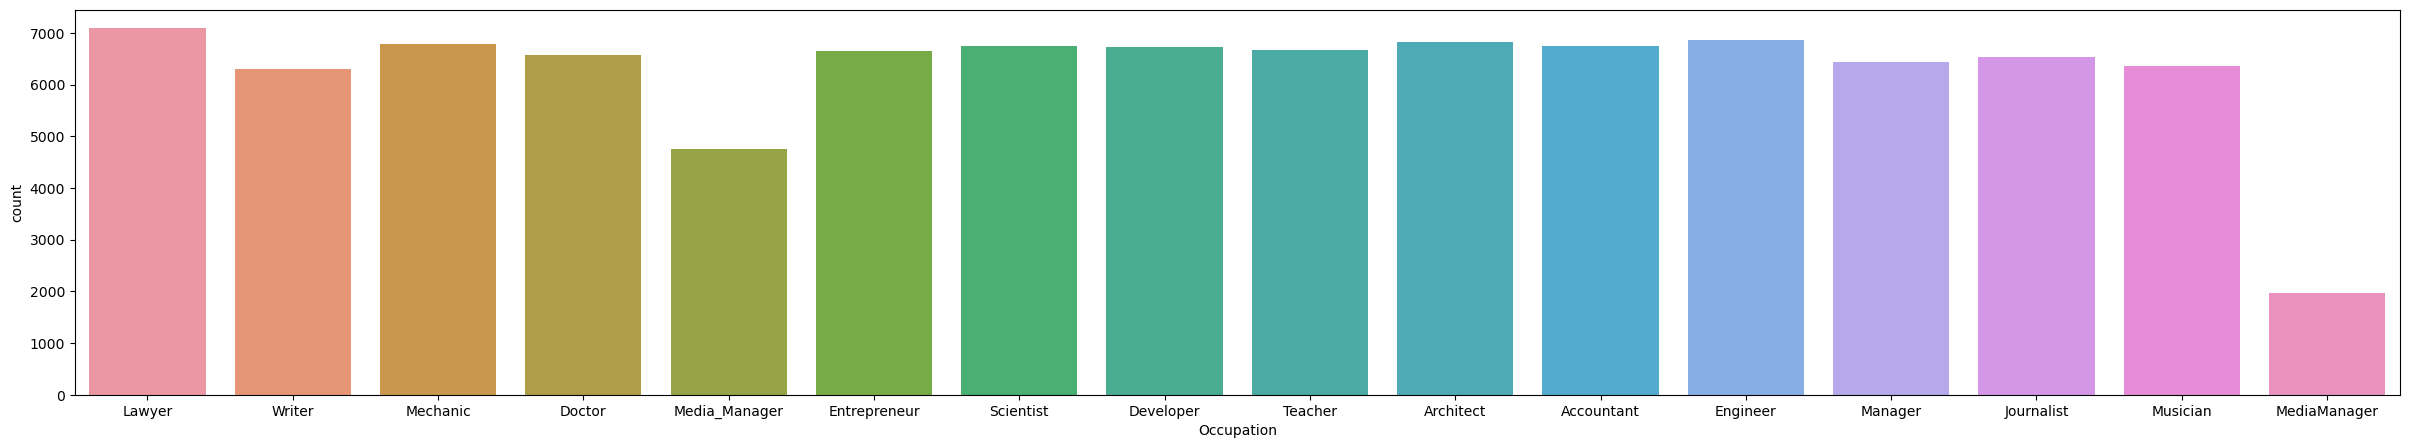

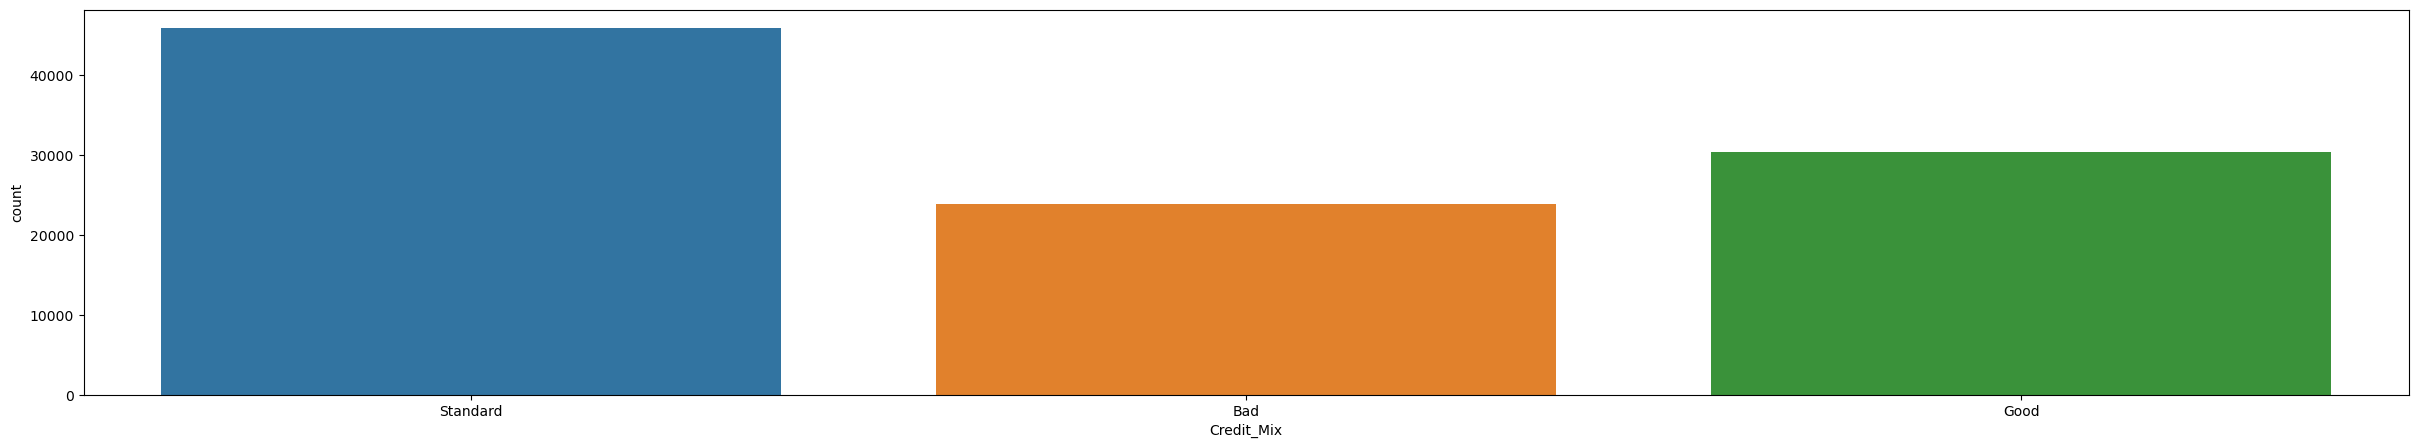

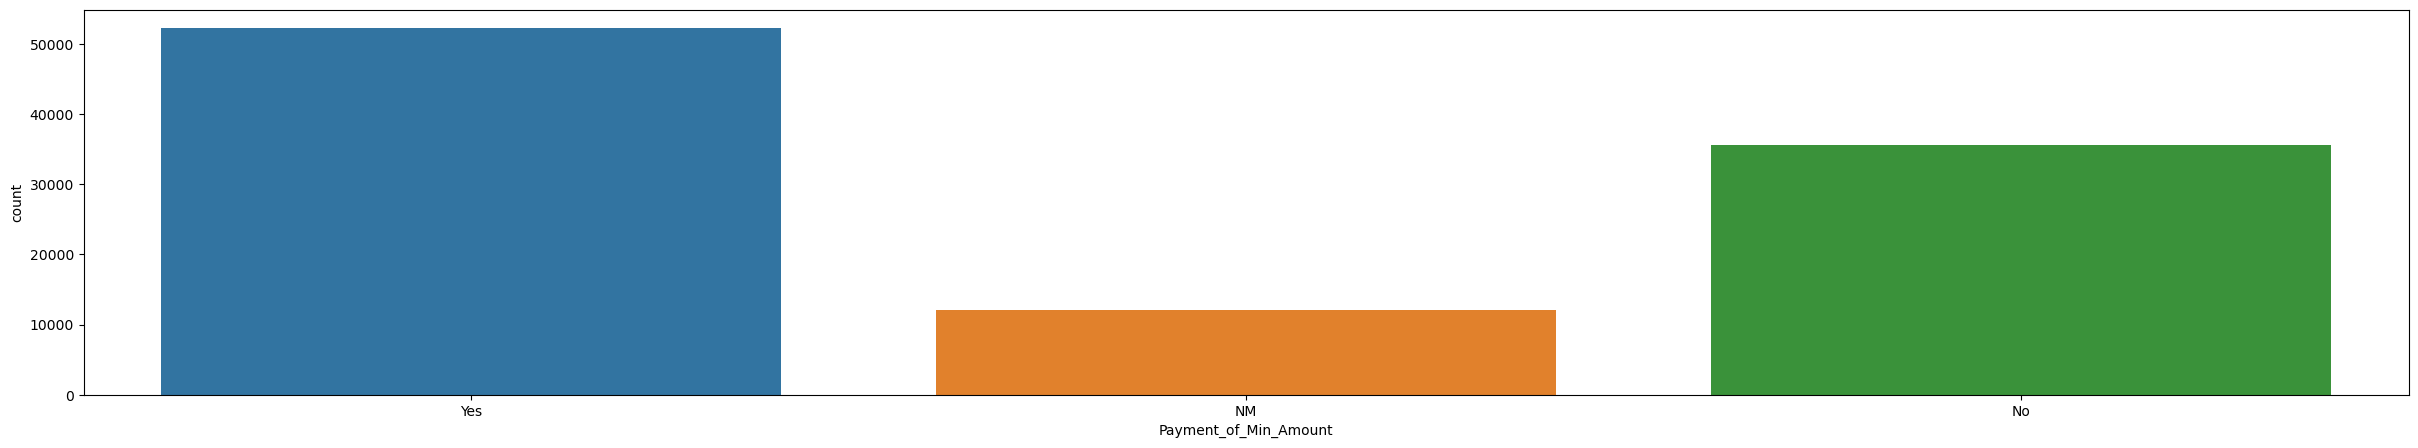

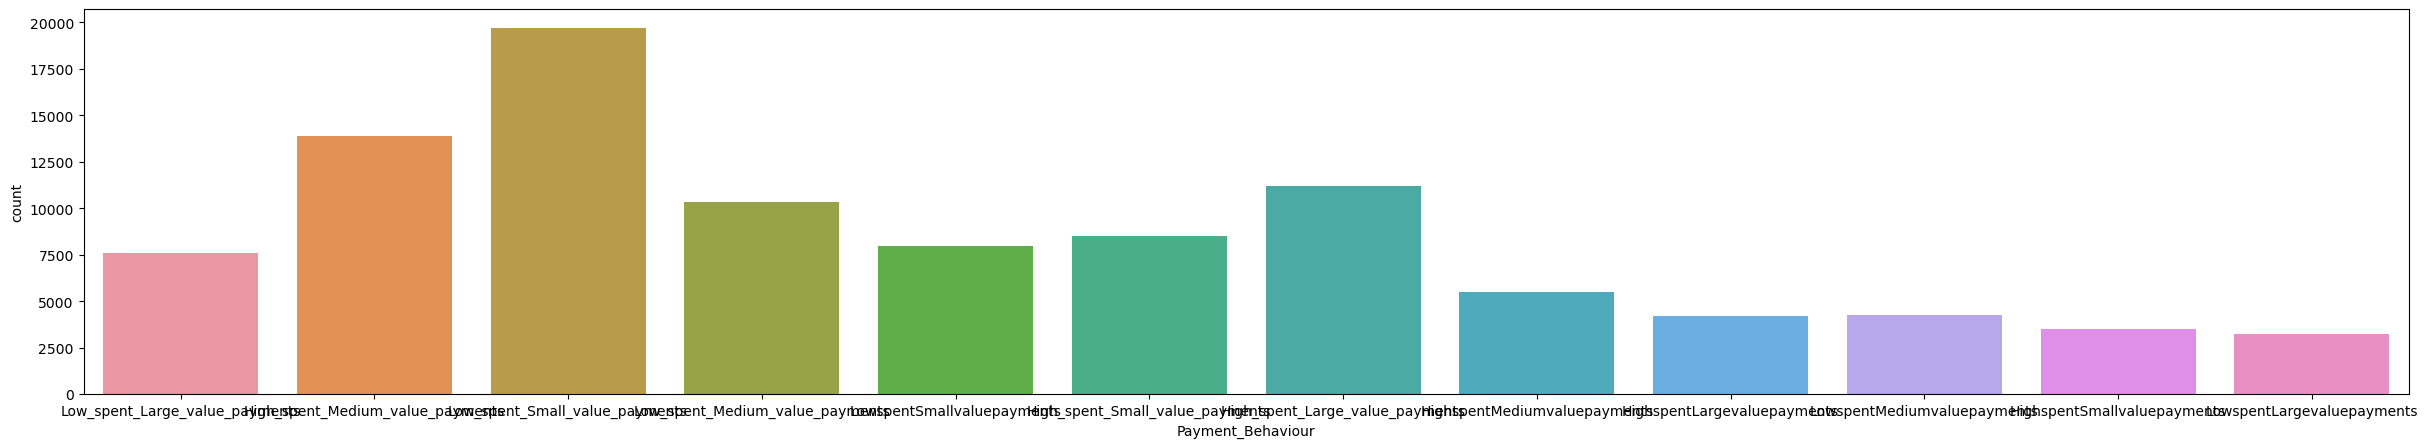

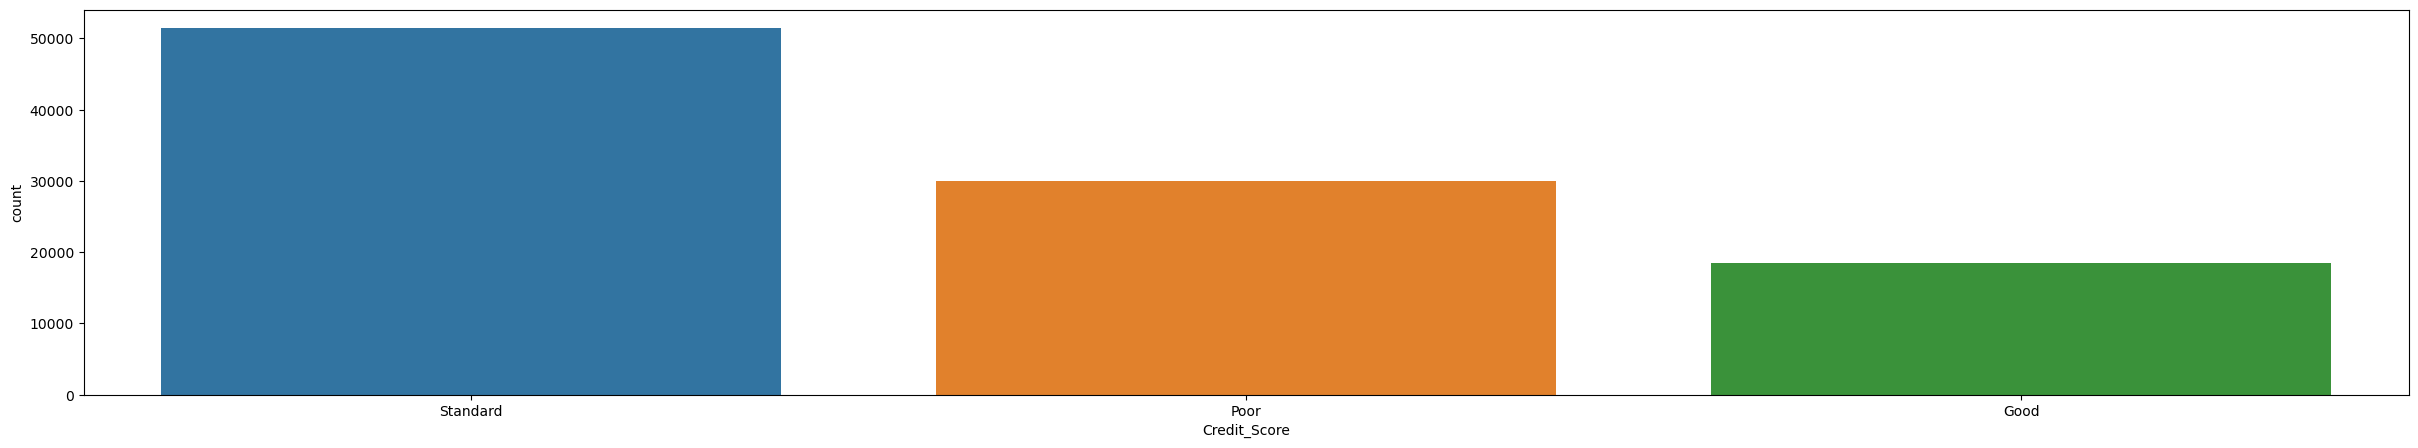

In [38]:
for i in categorical_vars:
    plt.figure(figsize=(30,5))
    sns.countplot(x = train[i])
    plt.xlabel(i)
    plt.show()

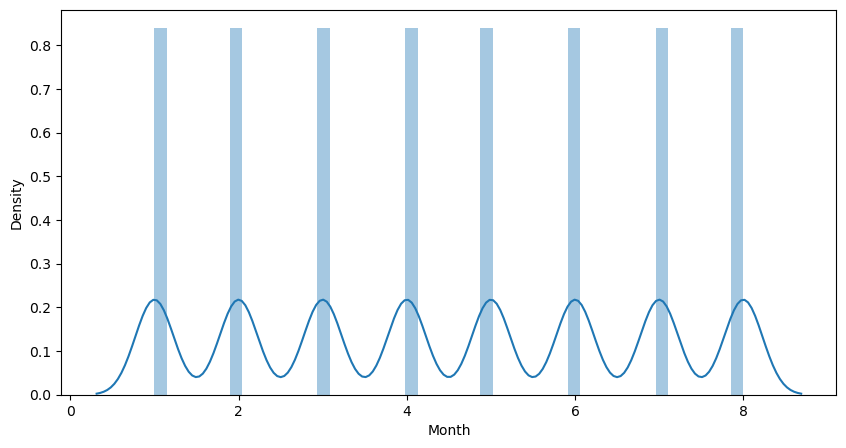

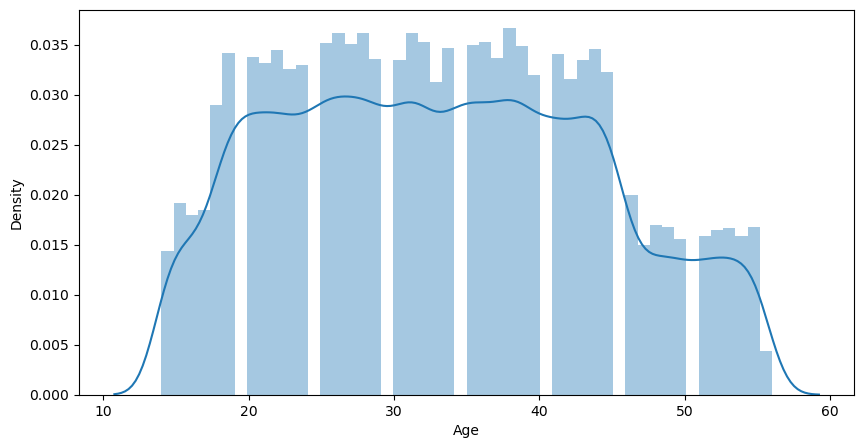

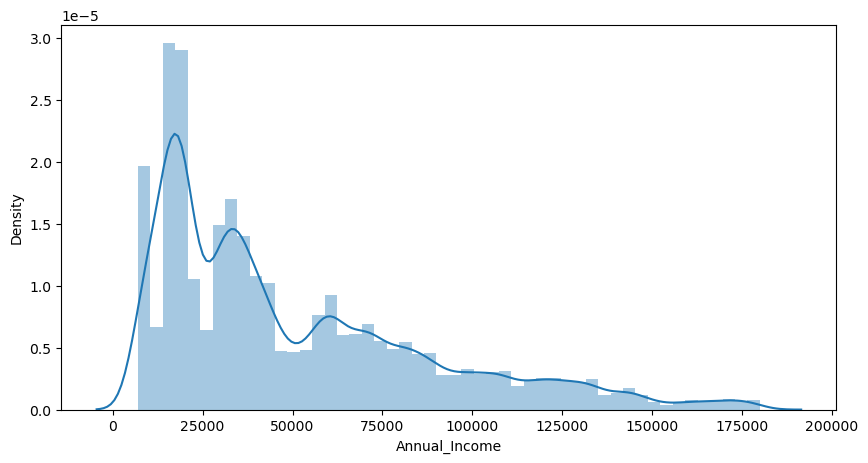

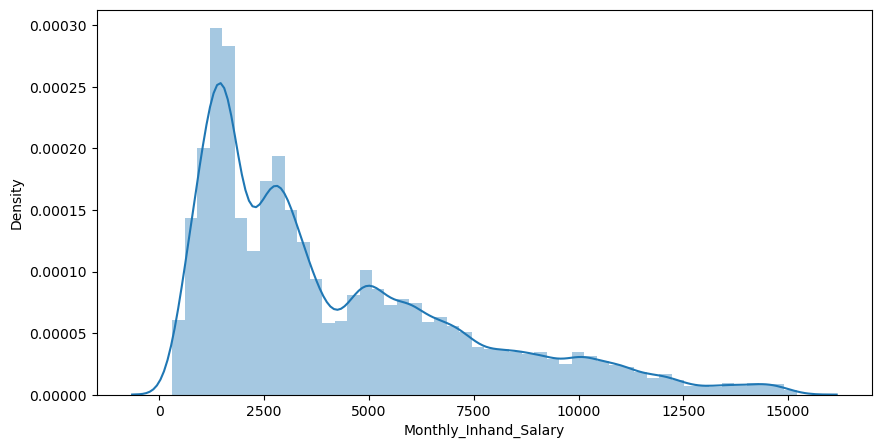

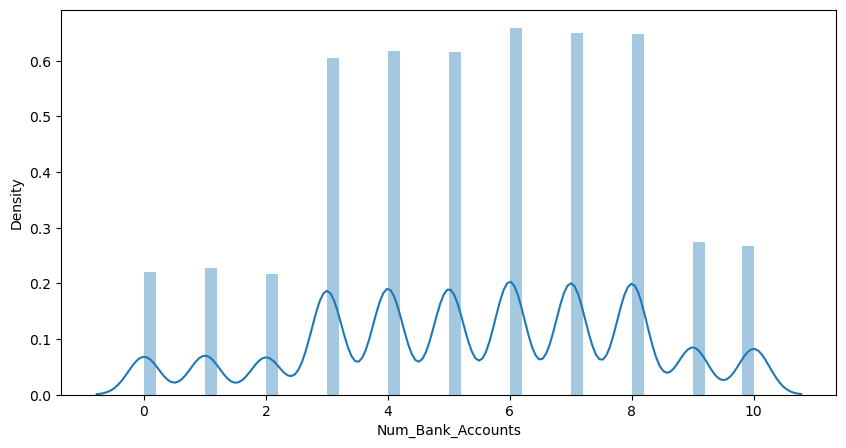

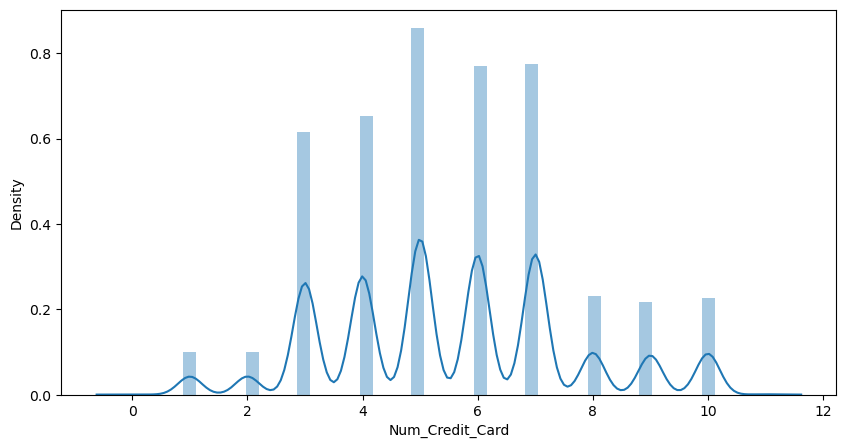

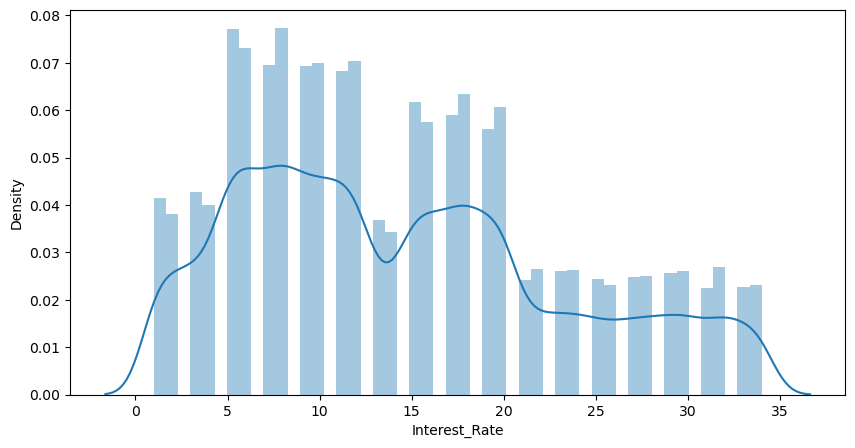

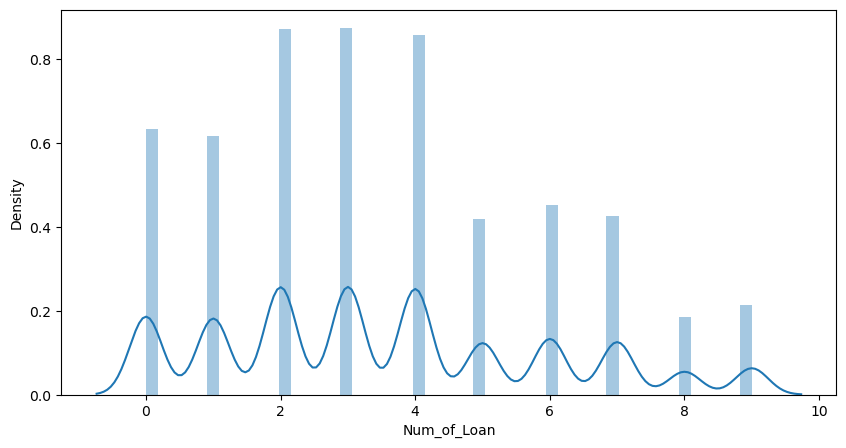

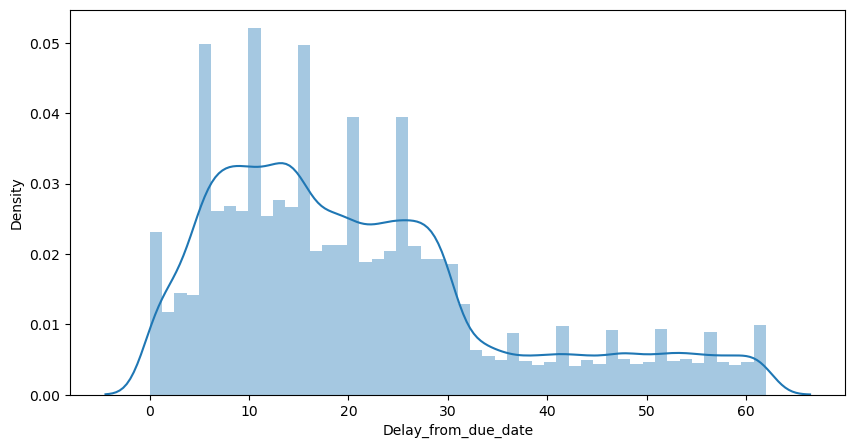

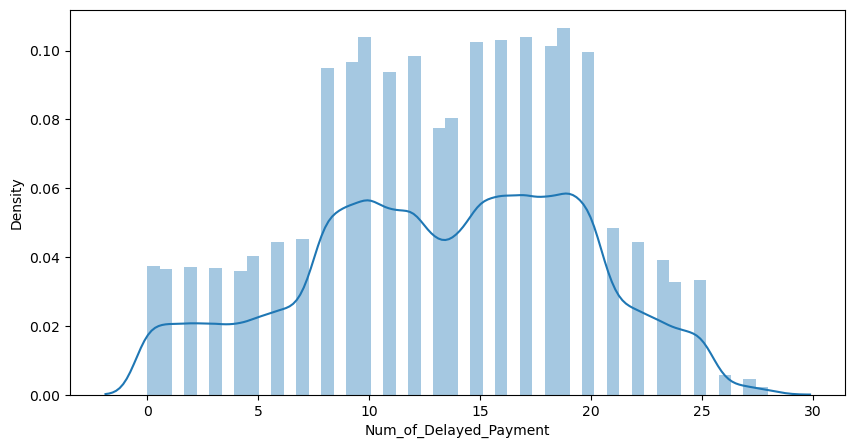

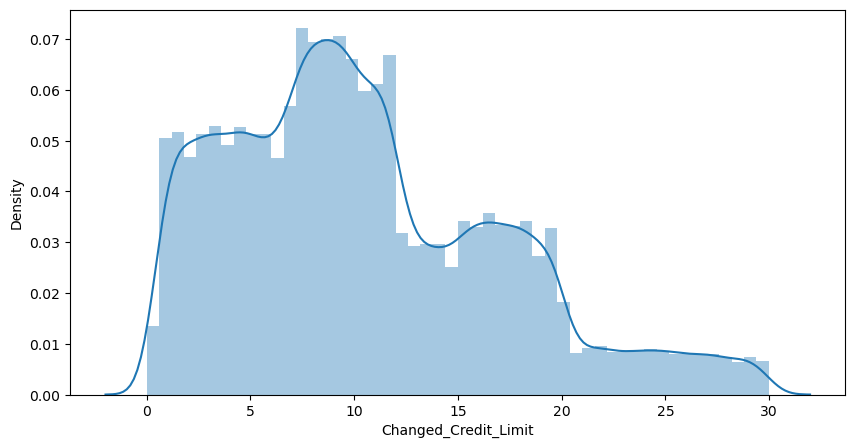

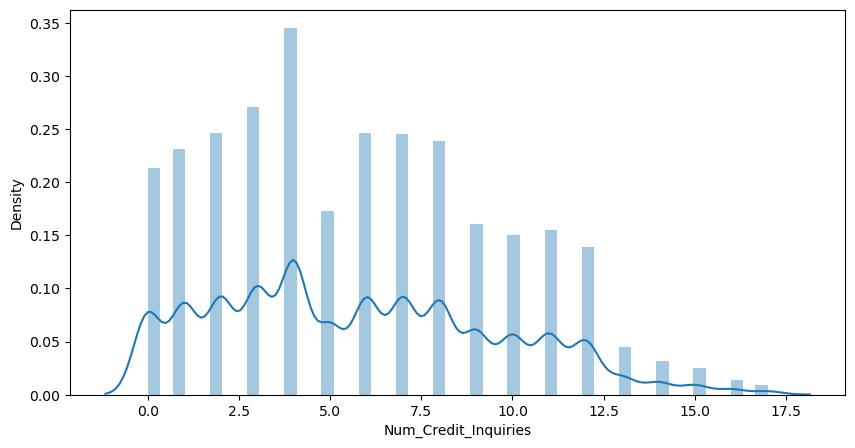

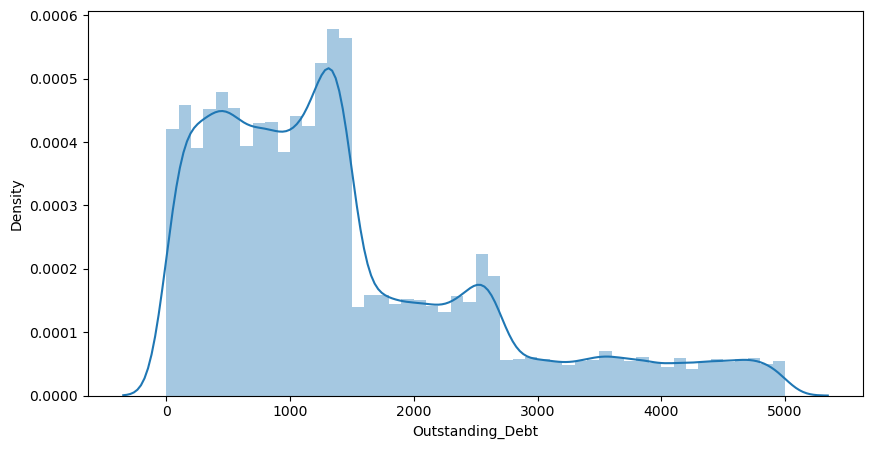

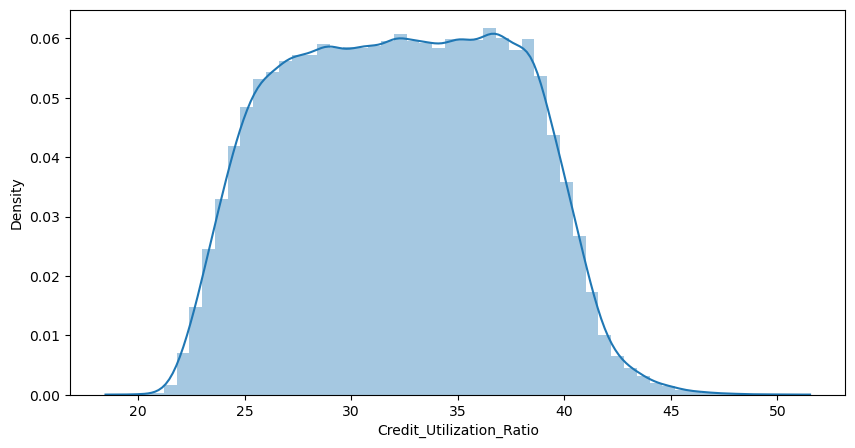

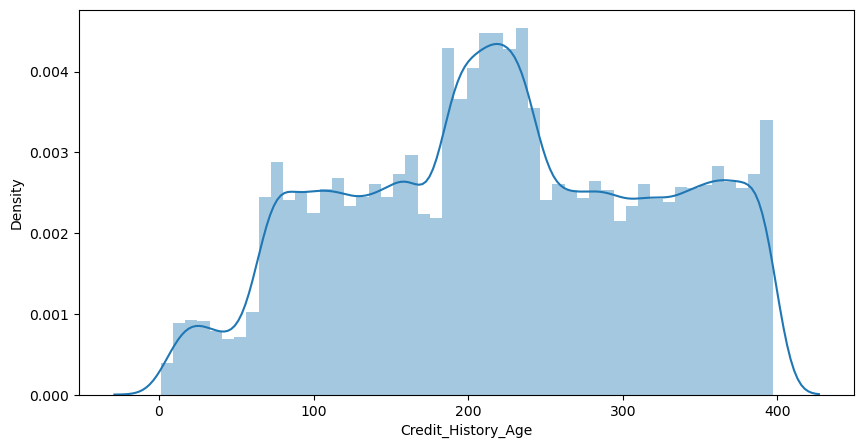

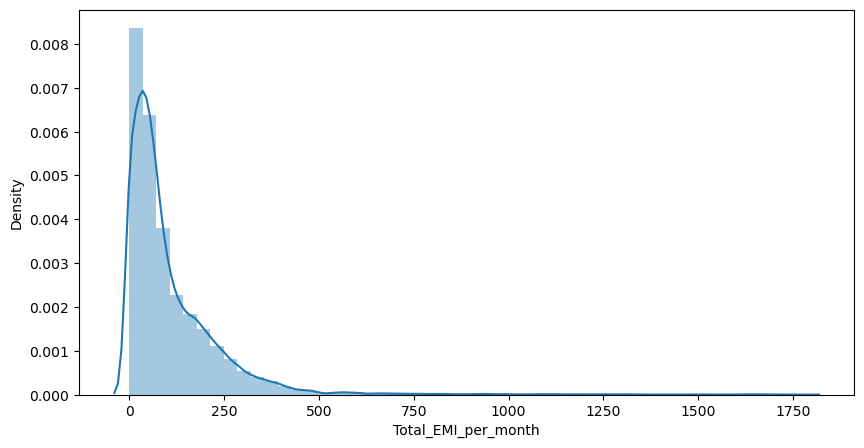

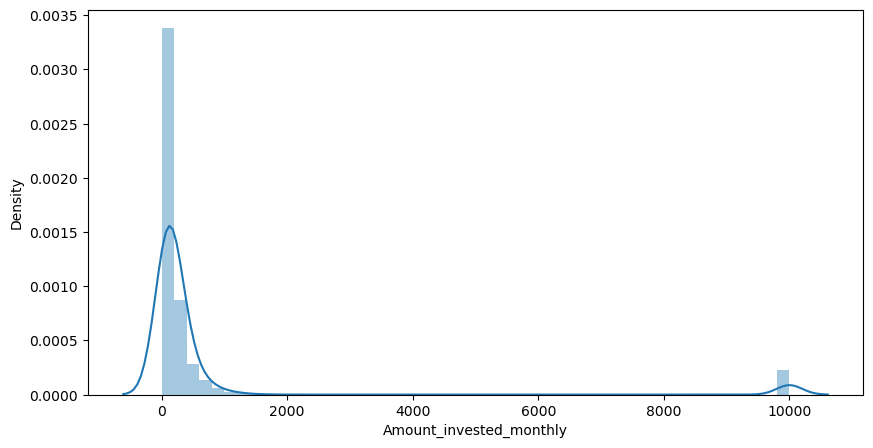

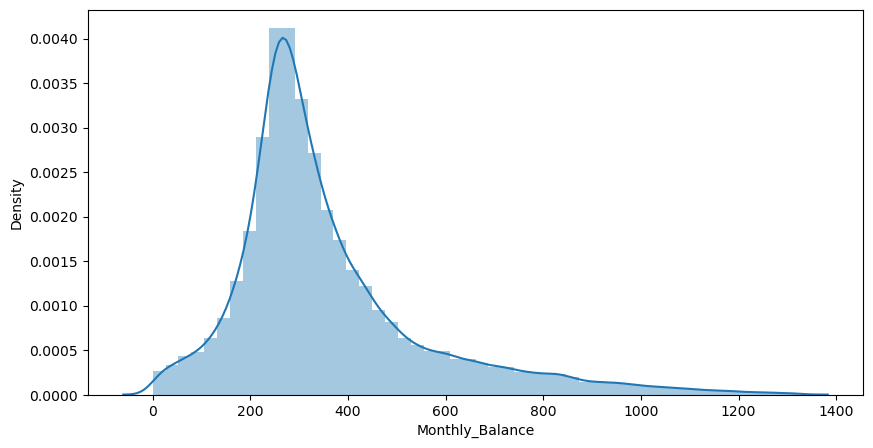

In [39]:
for i in numerical_vars:
    plt.figure(figsize = (10,5))
    sns.distplot(train[i])
    plt.xlabel(i)
    plt.show()

# Data Transformation

In [40]:
train.drop(columns = 'Customer_ID', axis = 0, inplace= True)

In [41]:
categorical_vars = [x for x in train.columns if train[x].dtype == "object"]
numerical_vars = [x for x in train.columns if x not in categorical_vars]

In [42]:
encoder = LabelEncoder()
for i in categorical_vars:
    train[i] = encoder.fit_transform(train[i].values.reshape(-1,1))

In [43]:
X = train.drop(columns='Credit_Score', axis = 1)
y = train['Credit_Score']
scaler = MinMaxScaler()
for i in X.columns:
    X[i] = scaler.fit_transform(X[i].values.reshape(-1,1))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 23) (30000, 23) (70000,) (30000,)


# Model Preparation

In [46]:
lr = LogisticRegression()
xg = XGBClassifier()
tree = DecisionTreeClassifier()
rf = RandomForestClassifier()
classifiers = [
    ('Logistic Regression',lr),
    ('Decision Tree',tree),
    ('XGBoost',xg),
    ('Random Forest',rf)
]

In [47]:
def model_evaluation(y_test, y_pred):
    classification_report(y_true=y_test, y_pred=y_pred)
    print("\n---------------------------------------------------")
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    plt.figure(figsize = (8,8))
    sns.heatmap(cm, annot = True, cmap = "Greens", fmt='.0f')
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')

In [48]:
for name, model in classifiers:
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring="accuracy", error_score='raise')
    avg_accuracy = scores.mean()
    avg_precision = cross_val_score(model, X_train, y_train, cv = 5, scoring="precision_macro").mean()
    avg_recall = cross_val_score(model, X_train, y_train, cv = 5, scoring="recall_macro").mean()
    print(f"Classifier: {name}")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average recall: {avg_recall:.4f}")
    print("\n-------------------------------------------------------------")

Classifier: Logistic Regression
Average Accuracy: 0.6610
Average Precision: 0.6495
Average recall: 0.6352

-------------------------------------------------------------
Classifier: Decision Tree
Average Accuracy: 0.7537
Average Precision: 0.7405
Average recall: 0.7417

-------------------------------------------------------------
Classifier: XGBoost
Average Accuracy: 0.8001
Average Precision: 0.7868
Average recall: 0.7952

-------------------------------------------------------------
Classifier: Random Forest
Average Accuracy: 0.8507
Average Precision: 0.8438
Average recall: 0.8477

-------------------------------------------------------------



---------------------------------------------------


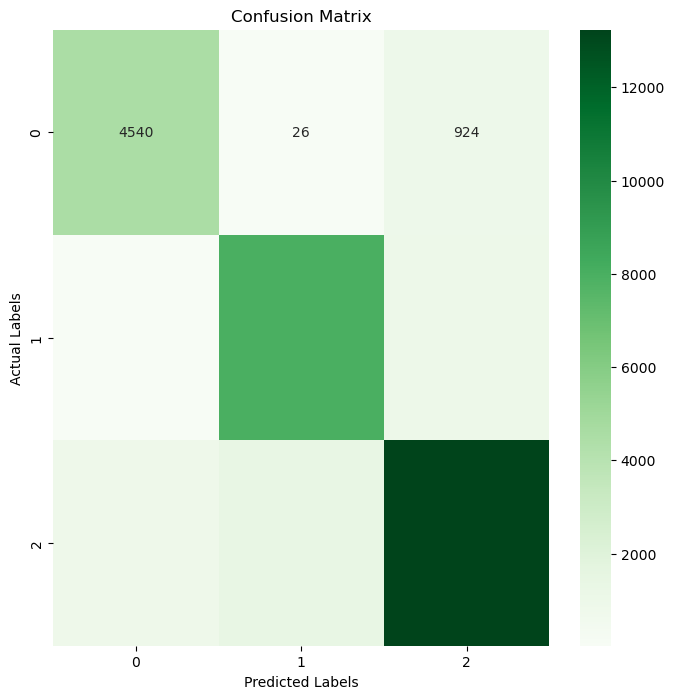

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_preds = rf.predict(X_test)
model_evaluation(y_test = y_test, y_pred=y_preds)